# Imports

In [1]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

# Ros modules
import rosbag2_py
import rclpy.serialization
from geometry_msgs.msg import PoseStamped, PoseWithCovarianceStamped

# Read Data

## Functions

In [2]:
 # Initialize the data that will be published
def read_bag(base_path, with_covariance=False):
    
    # Create a reader for the rosbag2 file
    storage_options = rosbag2_py.StorageOptions(uri=base_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format = "cdr", output_serialization_format = "cdr")
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)
    
    # Variables to store the data
    poses, stamps = [], []
    
    # Read until there are no more messages in the bag
    while reader.has_next():
    
        # Read the next message in the queue
        topic, msg, t = reader.read_next()

        if with_covariance:
            # Deserialize the msg to extract the x, y and z values
            deserialized_msg = rclpy.serialization.deserialize_message(msg, PoseWithCovarianceStamped)
                    # Convert the msg to a transformation matrix
            trans = np.array([deserialized_msg.pose.pose.position.x,
                              deserialized_msg.pose.pose.position.y,
                              deserialized_msg.pose.pose.position.z,])
            
            # Convert quaternion to rotation matrix
            quat = np.array([deserialized_msg.pose.pose.orientation.x,
                             deserialized_msg.pose.pose.orientation.y,
                             deserialized_msg.pose.pose.orientation.z,
                             deserialized_msg.pose.pose.orientation.w])
        else:
            # Deserialize the msg to extract the x, y and z values
            deserialized_msg = rclpy.serialization.deserialize_message(msg, PoseStamped)
            
            # Convert the msg to a transformation matrix
            trans = np.array([deserialized_msg.pose.position.x,
                              deserialized_msg.pose.position.y,
                              deserialized_msg.pose.position.z,])
            
            # Convert quaternion to rotation matrix
            quat = np.array([deserialized_msg.pose.orientation.x,
                             deserialized_msg.pose.orientation.y,
                             deserialized_msg.pose.orientation.z,
                             deserialized_msg.pose.orientation.w])
        
        # Build the transformation matrix
        rot = R.from_quat(quat).as_matrix()
        T = np.eye(4)
        T[:3,:3], T[:3,3] = rot, trans
        
        # Store the transformation matrix and the timestamp
        poses.append(T)
        stamps.append(t * 1e-9)  # ns → s
        
    return np.array(poses), np.array(stamps)
        

## Reading the data

In [3]:

%cd ..
%cd recordings/

original_bag_path = "pose/original/original_pose/original_pose.db3"

clean_bag_path = "pose/clean_pcl/clean_pcl_pose/clean_pcl_pose.db3"

noisy_bag_path = "pose/noisy_pcl/noisy_pcl_pose/noisy_pcl_pose.db3"

# Read poses and timestamps from rosbags
original_poses, original_stamps = read_bag(original_bag_path)
clean_poses, clean_stamps = read_bag(clean_bag_path)
noisy_poses, noisy_stamps = read_bag(noisy_bag_path)

/home/pablo-pc/GITHUB/TFG/project_ws/src
/home/pablo-pc/GITHUB/TFG/project_ws/src/recordings


/home/pablo-pc/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
[INFO] [1757347251.011868927] [rosbag2_storage]: Opened database 'pose/original/original_pose/original_pose.db3' for READ_ONLY.
[INFO] [1757347251.083757962] [rosbag2_storage]: Opened database 'pose/clean_pcl/clean_pcl_pose/clean_pcl_pose.db3' for READ_ONLY.
[INFO] [1757347251.117545624] [rosbag2_storage]: Opened database 'pose/noisy_pcl/noisy_pcl_pose/noisy_pcl_pose.db3' for READ_ONLY.


# Metrics

## Functions

In [4]:

def compute_ate(poses_est, poses_gt):
    # Align with Umeyama (scale fixed)
    mu_x = poses_est[:,:3,3].mean(axis=0)
    mu_y = poses_gt[:,:3,3].mean(axis=0)
    X = poses_est[:,:3,3] - mu_x
    Y = poses_gt[:,:3,3] - mu_y
    H = X.T @ Y
    U, S, Vt = np.linalg.svd(H)
    R_align = Vt.T @ U.T
    t_align = mu_y - R_align @ mu_x
    aligned_est = (R_align @ poses_est[:,:3,3].T).T + t_align
    errors = np.linalg.norm(aligned_est - poses_gt[:,:3,3], axis=1)
    rmse = np.sqrt(np.mean(errors**2))
    return errors, rmse

def compute_rpe(poses_est, poses_gt, delta=1):
    trans_errors, rot_errors = [], []
    for i in range(len(poses_gt)-delta):
        d_est = np.linalg.inv(poses_est[i]) @ poses_est[i+delta]
        d_gt  = np.linalg.inv(poses_gt[i])  @ poses_gt[i+delta]
        error = np.linalg.inv(d_gt) @ d_est
        trans_error = np.linalg.norm(error[:3,3])
        rot_error = np.arccos(np.clip((np.trace(error[:3,:3])-1)/2.0, -1, 1))
        trans_errors.append(trans_error)
        rot_errors.append(rot_error)
    return np.array(trans_errors), np.array(rot_errors)

def compute_kitti_drift(poses_est, poses_gt, seg_len=100.0):
    """
    Compute KITTI-style drift metrics.
    poses_est, poses_gt : (N,4,4)
    seg_len             : segment length in meters

    Returns: (trans_drift[%], rot_drift[deg/100m])
    """
    N = len(poses_gt)
    if N < 2:
        raise ValueError("Not enough ground-truth poses to compute drift.")

    # 1. Compute cumulative distance along GT
    dists = np.zeros(N)
    for i in range(1, N):
        dists[i] = dists[i-1] + np.linalg.norm(poses_gt[i][:3, 3] - poses_gt[i-1][:3, 3])

    total_length = dists[-1]
    if total_length < seg_len:
        print(f"[WARN] Trajectory too short ({total_length:.2f} m) for segment length {seg_len} m.")
        return np.array([]), np.array([])

    # 2. Compute drift for each segment
    trans_drifts, rot_drifts = [], []
    for i in range(N):
        future = np.where(dists >= dists[i] + seg_len)[0]
        if len(future) == 0:
            break
        j = future[0]
        d_est = np.linalg.inv(poses_est[i]) @ poses_est[j]
        d_gt  = np.linalg.inv(poses_gt[i])  @ poses_gt[j]
        error = np.linalg.inv(d_gt) @ d_est
        trans_err = np.linalg.norm(error[:3, 3]) / seg_len * 100  # %
        rot_err   = np.degrees(np.arccos(np.clip((np.trace(error[:3, :3]) - 1) / 2.0, -1, 1))) / seg_len * 100
        trans_drifts.append(trans_err)
        rot_drifts.append(rot_err)

    return np.array(trans_drifts), np.array(rot_drifts)

def plot_kitti_drift(trans_drift, rot_drift, seg_len):
    if len(trans_drift) == 0:
        print("[INFO] No drift values to plot.")
        return
    plt.figure(figsize=(10, 5))
    plt.plot(trans_drift, label="Translational Drift [% per seg]")
    plt.plot(rot_drift, label="Rotational Drift [deg/100m]")
    plt.title(f"KITTI-Style Drift per Segment (len={seg_len} m)")
    plt.xlabel("Segment index")
    plt.ylabel("Drift")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Mean Translational Drift: {np.mean(trans_drift):.2f}%")
    print(f"Median Translational Drift: {np.median(trans_drift):.2f}%")
    print(f"Mean Rotational Drift: {np.mean(rot_drift):.2f}°/100m")
    
def plot_phats(original_path, clean_path, noisy_path):
    # Create 3D scatter lines
    fig = go.Figure()

    xyz_original = original_path[:, :3, 3]  

    # Adding Original Path to figure
    fig.add_trace(go.Scatter3d(
        x=xyz_original[:,0], y=xyz_original[:,1], z=xyz_original[:,2],
        mode='lines+markers', marker=dict(size=4, color='green'),
        name="Original"
    ))


    xyz_clean = clean_path[:, :3, 3]  

    # Adding Calculated Path to figure
    fig.add_trace(go.Scatter3d(
        x=xyz_clean[:,0], y=xyz_clean[:,1], z=xyz_clean[:,2],
        mode='lines+markers', marker=dict(size=4, color='yellow'),
        name="Clean"
    ))

    xyz_noisy = noisy_path[:, :3, 3]  

    # Adding Calculated Path to figure
    fig.add_trace(go.Scatter3d(
        x=xyz_noisy[:,0], y=xyz_noisy[:,1], z=xyz_noisy[:,2],
        mode='lines+markers', marker=dict(size=4, color='red'),
        name="Noisy"
    ))

    # Labels & Layout
    fig.update_layout(
        title="Interactive 3D Path Visualization",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # Show the figure
    fig.show()

## Results

### Absolute Trajectory Error (ATE)
Description: Measures the absolute difference between estimated and ground-truth poses, after a rigid alignment (SE(3) or Sim(3) if monocular).

Interpretation: Low RMSE represents good global accuracy. Large spikes means drift accumulating or lost tracking.

#### ATE Results (Original vs Clean-PCL)

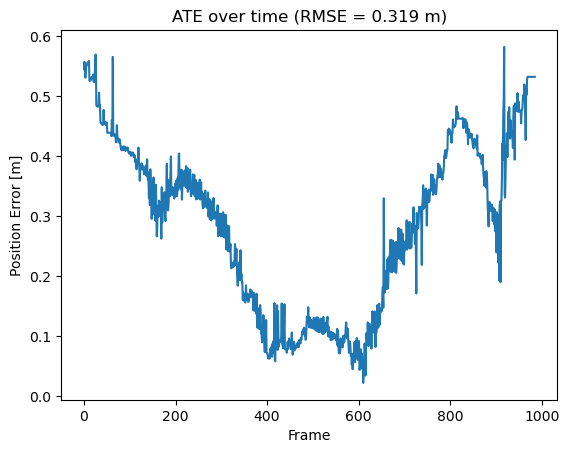

ATE RMSE: 0.319 m | Median: 0.312 m | Max: 0.582 m


In [5]:
errors, rmse  = compute_ate(original_poses, clean_poses)

plt.figure()
plt.plot(errors)
plt.title(f"ATE over time (RMSE = {rmse:.3f} m)")
plt.xlabel("Frame"); plt.ylabel("Position Error [m]")
plt.show()

print(f"ATE RMSE: {rmse:.3f} m | Median: {np.median(errors):.3f} m | Max: {np.max(errors):.3f} m")


### ATE Results (Original vs Noisy-PCL)

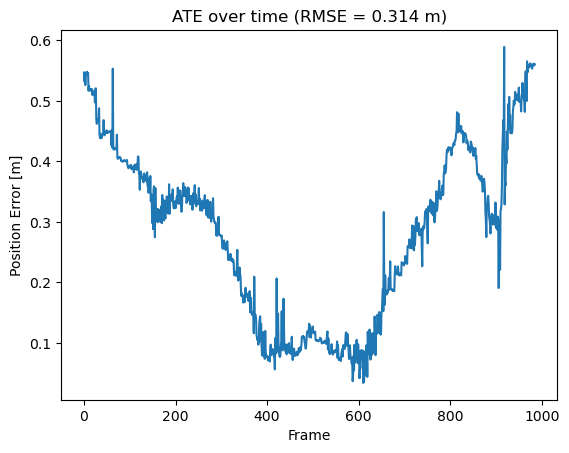

ATE RMSE: 0.314 m | Median: 0.306 m | Max: 0.589 m


In [6]:
errors, rmse  = compute_ate(original_poses, noisy_poses)

plt.figure()
plt.plot(errors)
plt.title(f"ATE over time (RMSE = {rmse:.3f} m)")
plt.xlabel("Frame"); plt.ylabel("Position Error [m]")
plt.show()

print(f"ATE RMSE: {rmse:.3f} m | Median: {np.median(errors):.3f} m | Max: {np.max(errors):.3f} m")

### Relative Pose Error (RPE)

Description: Compares relative motion between pose pairs over a fixed time/distance window. This shows local consistency and odometry drift.

Interpretation: Narrow histogram close to 0 means stable odometry.

#### RPE (Original vs Clean-PCL)

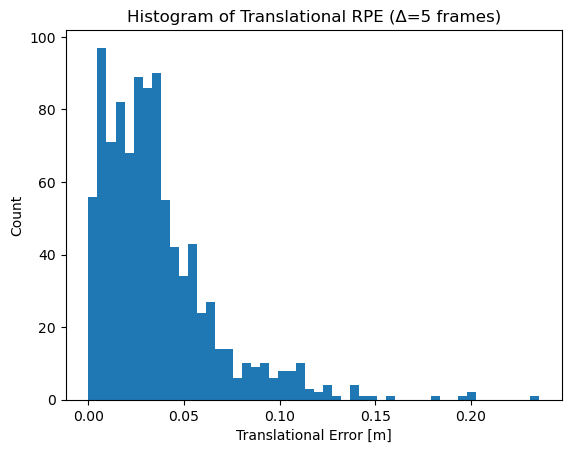

In [7]:
trans_errs, rot_errs = compute_rpe(original_poses, clean_poses, delta=5)
plt.figure()
plt.hist(trans_errs, bins=50)
plt.title("Histogram of Translational RPE (Δ=5 frames)")
plt.xlabel("Translational Error [m]"); plt.ylabel("Count")
plt.show()

#### RPE (OriginaL vs Noisy-PCL)

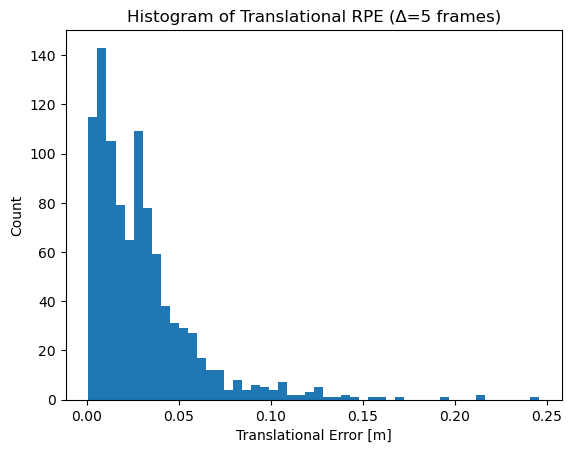

In [8]:
trans_errs, rot_errs = compute_rpe(original_poses, noisy_poses, delta=5)
plt.figure()
plt.hist(trans_errs, bins=50)
plt.title("Histogram of Translational RPE (Δ=5 frames)")
plt.xlabel("Translational Error [m]"); plt.ylabel("Count")
plt.show()

### KITTI-style Drift per Distance

Description: Computes translational (%/100m) and rotational (°/100m) drift over segments.

Interpretation: Flat low drift (<1-2%) means good odometry.

#### KITTI-style Drift per Distance (Original vs Clean-PCL)

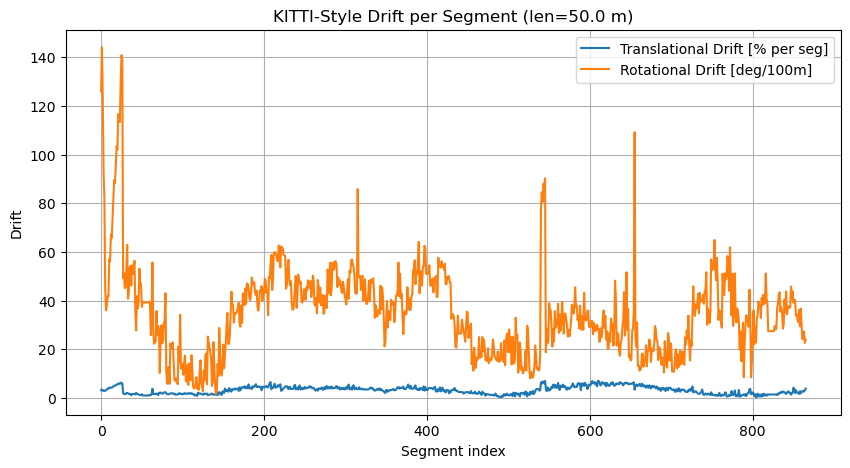

Mean Translational Drift: 3.15%
Median Translational Drift: 3.21%
Mean Rotational Drift: 34.97°/100m


In [9]:
trans_drift, rot_drift = compute_kitti_drift(original_poses, clean_poses, seg_len=5.0)
plot_kitti_drift(trans_drift, rot_drift, seg_len=50.0)

#### KITTI-style Drift per Distance (OriginaL vs Noisy-PCL)

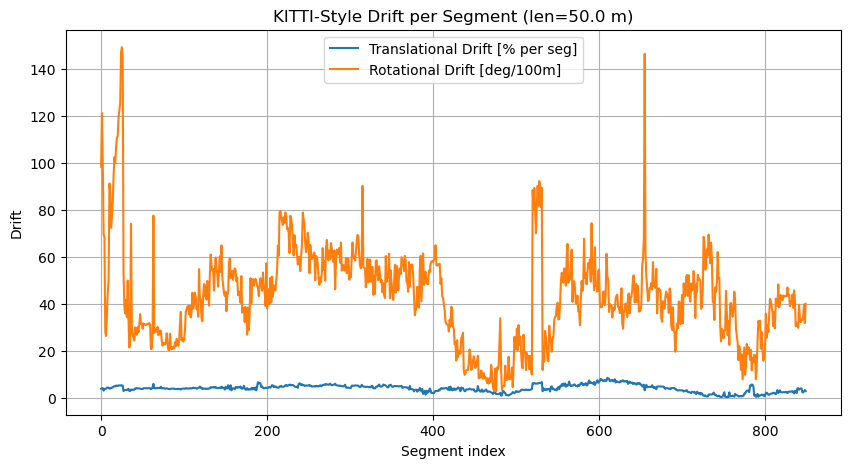

Mean Translational Drift: 4.13%
Median Translational Drift: 4.22%
Mean Rotational Drift: 43.40°/100m


In [10]:
trans_drift, rot_drift = compute_kitti_drift(original_poses, noisy_poses, seg_len=5.0)
plot_kitti_drift(trans_drift, rot_drift, seg_len=50.0)

## Visualization

In [11]:
plot_phats(original_poses, clean_poses, noisy_poses)